In [2]:
# from community import community_louvain
import gc
import logging
import os
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing.pool import ThreadPool as Pool
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import random
import scipy
from scipy.optimize import differential_evolution, basinhopping, linprog
import tensorflow as tf
import tensorflow_constrained_optimization as tfco
import time
import warnings
logger = tf.get_logger()
print(scipy.__version__) # 1.9.3
os.environ['KMP_DUPLICATE_LIB_OK']='True'

1.9.3


In [3]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, DnnResult) or isinstance(obj, AlgoResult):
            return json.dumps(obj.__dict__, cls = NpEncoder)
        if isinstance(obj, set):
            return list(obj)
        return json.JSONEncoder.default(self, obj)

In [72]:
logging.basicConfig(encoding='utf-8', level=logging.DEBUG,
                    force = True)

In [5]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
threads_count = 1
pool = Pool(threads_count)
mp.cpu_count()
use_parallelizing = False

In [6]:
class DnnResult():
    def __init__(self, graph_size, theta, stuck, loss_arr, mis_size_arr):
        self.graph_size = graph_size
        self.theta = theta
        self.stuck = stuck
        self.loss_arr = loss_arr
        self.mis_size_arr = mis_size_arr
        self.local_improvement = None
        self.mis = None

In [7]:
class AlgoResult():
    def __init__(self):
        self.communities_result = []
        self.simplicial_result = None
        self.local_improvement_result = None
        self.simp_nodes_len = 0
        self.forbiden_edges = None
        self.mis = None
        self.mis_after_forbidden_edges_processed_len = 0
        self.mis_in_left_nodes = None

In [8]:
class ValidationResult():
    def __init__(self, valid, can_add_nodes, contains_extra_nodes):
        self.valid = valid
        self.can_add_nodes = can_add_nodes
        self.contains_extra_nodes = contains_extra_nodes        

In [9]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [10]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [11]:
def clip(l,r,x):
    return max(l,min(r,x))

def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c),dtype= 'float32')
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_theta(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
#     logging.debug("Max degree = {}".format(max_degree))
    if max_degree == 0:
        return np.array([1 for i in range(n)])
#     return np.array([1 for i in range(n)])
    return np.array([clip(0,1,1 - G.degree(i)/max_degree + random.random()/10000) for i in range(n)])
#     return np.array([random.random() for i in range(n)])

def build_network(G):
    logging.debug("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    theta = build_theta(G)
#     logging.debug("Initial theta = {}".format(theta))
    return (W,b,w, theta, C)


In [63]:
def get_result_nodes(theta, alpha = 0.9):
    return set(np.argwhere(theta > alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, result_nodes):
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    node_not_connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False
            
def graph_has_no_edges(G, result_nodes):
    for v in result_nodes:
        for edge in G.neighbors(v):
            if edge in result_nodes:
                return False
    return True

def mis_is_valid(G, mis):
    has_extra_nodes = not graph_has_no_edges(G, mis)
    not_connected_nodes_exist = not_connected_nodes_exist_in_G(G, mis)
    return ValidationResult(not has_extra_nodes and not not_connected_nodes_exist,
                            not_connected_nodes_exist, has_extra_nodes)
               
def result_is_valid(G, theta):
    result_nodes = get_result_nodes(theta)
    return mis_is_valid(G, result_nodes).valid

def network(theta,e_n,W_t,b,w_t):
    h = tf.math.multiply(e_n,theta)
    h = tf.linalg.matvec(W_t,h)
    h = tf.add(h,b)
    h = tf.nn.relu(h)
    h = tf.tensordot(w_t,h, 1)
    return h
    
def network_evol(theta,e_n,W_t,b,w_t):
    return network(theta,e_n,W_t,b,w_t).numpy()

def loss(theta,e_n,W_t,b,w_t,h_d):
#     with tf.GradientTape() as tape:
    h1 = tf.math.multiply(e_n,theta)
    h2 = tf.linalg.matvec(W_t,h1)
    h3 = tf.add(h2,b)
    h4 = tf.nn.relu(h3)
    h5 = tf.tensordot(w_t,h4, 1)
    diff = (h5-h_d)**2   
#     logging.debug("Gradient = {}".format(tape.gradient(diff, theta)))
#     logging.debug("Loss = {}".format(diff))
    return diff

def loss_evol(theta,e_n,W_t,b,w_t,h_d):
    h = network_evol(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2  

def evolutionary_train(n,theta,e_n,W_t,b,w_t,h_d):
    bounds = [(0,1) for i in range(n)]
    theta = differential_evolution(loss_evol, bounds, x0 = theta, args = (e_n,W_t,b,w_t,h_d))
    theta = theta.x
    return DnnResult(theta, False)

def vectors_are_close(a,b):
    norm_diff = np.linalg.norm(a-b)
    return norm_diff < 1e-6 

class MinimizationProblem(tfco.ConstrainedMinimizationProblem):
    def __init__(self, loss_fn, weights):
        self._loss_fn = loss_fn
        self._weights = weights
    
    @property
    def num_constraints(self):
        return len(self._weights.numpy()) * 2
   
    def objective(self):
        return self._loss_fn()
   
    def constraints(self):
        theta = self._weights
        lt_or_eq_one = theta - 1
        gt_or_eq_zero = -theta
        constraints = tf.stack([lt_or_eq_one, gt_or_eq_zero])
        return constraints

def gradient_train(G, max_epochs, theta,e_n,W_t,b,w_t,h_d):
    epoch = 0

    def local_loss():
        return loss(theta,e_n,W_t,b,w_t,h_d)
    
    
    optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    var_list = theta
#     problem = MinimizationProblem(local_loss, theta)
    
#     optimizer = tfco.ProxyLagrangianOptimizerV2(
#       optimizer=tf.optimizers.Adam(learning_rate=0.1,),
# #       constraint_optimizer=tf.optimizers.Adam(learning_rate=0.1,),
#       num_constraints=problem.num_constraints)
    
#     var_list = ([theta] + list(problem.trainable_variables) + optimizer.trainable_variables())
    
    solver_stuck = False
    loss_arr = list()
    loss_arr.append(local_loss().numpy())
    mis_size_arr = list()
    mis_size_arr.append(len(get_result_nodes(theta.numpy())))
    previous_theta = np.copy(theta.numpy())
#     logging.debug("theta = {}".format(theta))
    while not result_is_valid(G, theta) and epoch < max_epochs and not solver_stuck:
#     while epoch < max_epochs and not solver_stuck:
#     while not result_is_valid(G, theta):
#         logging.debug("Epoch = {}".format(epoch))
#         optimizer.minimize(problem, var_list=var_list)
        optimizer.minimize(local_loss, var_list=var_list)
        loss_arr.append(local_loss().numpy())
        mis_size_arr.append(len(get_result_nodes(theta)))
#         logging.debug("theta = {}".format(theta))
#         previous_error = local_loss()
#         logging.debug("Loss = {}".format(previous_error))
        epoch+=1
#         logging.debug("Theta={}".format(theta.numpy()))
#         logging.debug("Previous theta = {}".format(previous_theta))
        if np.allclose(previous_theta, theta.numpy()):
            logging.debug("Solver stuck")
            solver_stuck = True
#         if vectors_are_close(previous_theta,theta.numpy()):
#             logging.debug("Solver approaches plateu.")
#             break
        previous_theta = np.copy(theta.numpy())
    if result_is_valid(G, theta):
        logging.debug("Optimal solution found. Cardinality = {}".format(len(get_result_nodes(theta))))
        logging.debug("dNN solution is correct")
    else:
        logging.debug("dNN solution is not correct")
        if not_connected_nodes_exist_in_G(G, get_result_nodes(theta)):
            logging.debug("Can add more nodes to IS")
        else:
            logging.debug("There are extra nodes in IS")
    if epoch == max_epochs:
        logging.debug("Epochs exceeded maximum")
        
    logging.debug("Total epochs = {}".format(epoch))
    logging.debug("dNN solution lenghth = {}".format(len(get_result_nodes(theta))))
    return DnnResult(len(G.nodes()), theta.numpy(), solver_stuck or epoch == max_epochs, loss_arr, mis_size_arr)

def train_network(G, max_epochs, method="gradient"):
    (W,b,w, theta, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float32')
    b = tf.constant(b, dtype = 'float32')
    w_t = tf.constant(w.T, dtype = 'float32')
    theta = tf.Variable(theta,
                        trainable=True,
                        constraint = lambda x: tf.clip_by_value(theta,0,1),
                        dtype = 'float32')
    e_n = tf.constant(np.ones((n)),dtype = 'float32')
    h_d = tf.constant((n*n)/(-2),dtype = 'float32') 

    if method == "evolutionary":
        result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    elif method == "gradient":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
    elif method == "mixed":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
        if not result_is_valid(G, result.theta):
            logging.debug("Gradient method did not find solution. Trying evolutionary method...")
            theta = tf.Variable(build_theta(G),
                        trainable=True,
                        dtype = 'float32')
            result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    return result

In [13]:
def graphSets(graph): # Determinative algorithm to check correctness of the solution. Works too long for graphs >= 30 nodes.
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [14]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()

In [15]:
def output_info(algo_result):
    pass

In [16]:
def draw_plots(algo_result):
    com_index = 0
    for com_res in algo_result.communities_result:
        iterations = len(com_res.loss_arr)
        x_axis = [i for i in range(iterations)]

        fig,ax = plt.subplots()
#loss plot
        ax.plot(x_axis, com_res.loss_arr, color="red")
        ax.set_title("Community " + str(com_index))
        ax.set_xlabel("dNN iterations", )
        ax.set_ylabel("loss", color="red")
        
#mis size plot
        ax2 = ax.twinx()
        ax2.plot(x_axis, com_res.mis_size_arr, color="blue")
        ax2.set_ylabel("MIS size", color = "blue")
        
        plt.show()
        com_index+=1

In [17]:
def calculate_DNN_result(G, theta, threshold = 0.5, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(theta)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()
        
def calculate_DNN_result(G, result, draw_graph = True, plot_name = "default.png"):
    MIS = result.mis
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['green' if node in MIS else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True, font_color="white") # node lables
        plt.savefig(plot_name)
        plt.show()
        
        draw_plots(result)

In [18]:
def draw_DNN_result(G, max_epochs = 100,):
    MIS = calculate_large_G(G)
    calculate_DNN_result(G, MIS, draw_graph=True)

In [19]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

In [20]:
# compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

In [21]:
# compareResults(nx.graph_atlas(1000),draw_graph=True)

In [22]:
# compareResults(nx.gnp_random_graph(20, 0.1), 200, True) #Expected result around 12-14

In [23]:
# compareResults(nx.gnp_random_graph(50, 0.075), max_epochs = 1000)

In [24]:
# compareResults(nx.gnp_random_graph(100, 0.1), max_epochs = 1000, draw_graph=False)

In [25]:
def find_inter_cluster_edges(G, communities):
    edges = dict()
    for com in communities:
        for node_i in communities[com]:
            for neighbour_i in G.neighbors(node_i):
                if neighbour_i not in communities[com]:
                    if edges.get(node_i) is not None:
                        edges[node_i].add(neighbour_i)
                    else:
                        edges[node_i] = {neighbour_i}
                    if edges.get(neighbour_i) is not None:
                        edges[neighbour_i].add(node_i)
                    else:
                        edges[neighbour_i] = {node_i}
    return edges

In [26]:
def find_forbidden_edges(G, R, independent_sets):
#     logging.info("independent_sets={}".format(independent_sets))
    forbidden = []
    for u, edges in R.items():
        if u in independent_sets:
            for v in edges:
                if v in independent_sets:
                    forbidden.append((u, v))
#     logging.info("F={}".format(forbidden))
    return forbidden

In [27]:
def collect_list_by_dicts_key(partitions):
    communities = {}
    for key, val in partitions.items():
        if communities.get(val) == None:
            communities[val] = [key]
        else:
            communities[val].append(key)
    return communities

In [28]:
def collect_communities_to_map(communities):
    new_com = {}
    index = 0
    for com in communities:
        new_com[index] = com
        index+=1
    return new_com

In [29]:
def build_G_from_nodes(G, nodes):
    communities = {}
    N = len(nodes)
    new_G = nx.Graph()
    index_map = dict()
    node_map = dict()
    index = 0
    for node in nodes:
        index_map[index] = node
        node_map[node] = index
        new_G.add_node(index)
        index+=1
    for i in nodes:
        for j in nodes:
            if G.has_edge(i,j):
                new_G.add_edge(node_map[i], node_map[j])
                new_G.add_edge(node_map[j], node_map[i])
    return (new_G, index_map, node_map)

In [30]:
def node_is_new_candidate(G, node, mis):
    for w in G.neighbors(node):
        neighbors_in_mis_count = 0
        if w not in mis:
            for n_w in G.neighbors(w):
                if n_w in mis:
                    neighbors_in_mis_count += 1
                    if neighbors_in_mis_count == 2:
                        break
            if neighbors_in_mis_count == 1:
                return (True, w)
    return (False, -1) 

In [31]:
def get_node_with_most_occurences(F):
    count_dict = dict()
    for edge in F:
        for node in edge:
            if node in count_dict:
                count_dict[node]+=1
            else:
                count_dict[node]=0
    maximum = 0
    max_node = None
    for node in count_dict:
        if count_dict[node] > maximum:
            max_node = node
    return node

In [32]:
def replace_node_if_possible(G,F,mis,node):
    (can_be_replaced, new_node) = node_is_new_candidate(G,node,mis)
    if can_be_replaced:
        logging.debug("mis = {}".format(mis))
        logging.debug("Node {} can be replaced with {}".format(node, new_node))
        mis.remove(node)
        mis.add(new_node)
        return True
    return False 

In [33]:
def replace_forbiden_nodes(G,R,F,mis):
    logging.debug("Replacing forbiden nodes")
    while len(F) > 0:
#         logging.debug("F = {}".format(F))
        replaced = False
        for edge in F:
            for node in edge:
                replaced = replace_node_if_possible(G,F,mis,node)
                if replaced:
                    break
            if replaced:
                break
        if not replaced:
            node_to_be_removed = get_node_with_most_occurences(F)
            logging.debug("Removing node {}.".format(node_to_be_removed))
            mis.remove(node_to_be_removed)
        F = find_forbidden_edges(G, R, mis)
    return mis

In [34]:
def build_G_from_left_nodes(G, nodes):
    mis_with_neighbours = set()
    for node in nodes:
        mis_with_neighbours.add(node)
        for neighbour in G.neighbors(node):
            mis_with_neighbours.add(neighbour)
    nodes_left_to_process = set(G.nodes()).difference(mis_with_neighbours)
    return build_G_from_nodes(G,nodes_left_to_process)

In [35]:
def calculate_mis_with_left_nodes(G, mis_list, max_epochs,method):
    (left_G, left_index_map, left_node_map)  = build_G_from_left_nodes(G, mis_list)
    logging.debug("Left nodes = {}".format([left_index_map[node] for node in left_G.nodes()]))
    logging.debug("Left nodes length = {}".format(len(left_G.nodes())))
    if len(left_G.nodes()) > 100:
        mis = calculate_large_G(left_G, max_epochs)
    elif len(left_G.nodes()) > 0:
        logging.debug("In left_G.nodes()) > 0")
        mis = validate_dnn_result(train_network(left_G, max_epochs,method),left_G)
    else:
        mis = {}
    mis_correct = [left_index_map[node] for node in mis]
    logging.debug("mis of left nodes = {}".format(mis_correct))
    mis_final = mis_list.union(mis_correct)
    return mis_final

In [36]:
def build_U_from_IS(_lambda, IS,G,):
    if len(IS) == 0:
        return []
    degree_list_ascending = [(G.degree(node),node) for node in IS]
    degree_list_ascending.sort(key=lambda pair: pair[0])
    return [pair[1] for pair in degree_list_ascending[:min(_lambda, len(IS))]]

In [37]:
def validate_dnn_result(dnn_result, G):
    if dnn_result.stuck:
        if len(G.edges()) < 50:
            logging.debug("Solver stuck. Using local search...")
#             dict_G = nx.to_dict_of_lists(G)
#             mis = graphSets(dict_G)
            mis = local_improvement(G,[0])
#             logging.debug("Local search mis length = {}".format(len(mis)))
            logging.debug("Local search mis length = {}".format(len(mis)))
#             
        else:
            communities = collect_communities_to_map(nx_comm.louvain_communities(G, resolution = 1.3, seed=seed))
            if len(communities) > 1:
                logging.debug("Solver stuck. Too many edges to process for local search. Trying split graph to communities...")
                new_result = calculate_large_G(G, resolution = 1.3)
                mis = new_result.mis
            else:
                logging.warning("Solver stuck. Too many edges to process for local search in 1 community. Picking any MIS...")
                mis = nx.maximal_independent_set(G)
            logging.debug("validate_dnn_result:IS length = {}".format(len(mis)))
        dnn_result_nodes = get_result_nodes(dnn_result.theta)
        if len(dnn_result_nodes) > len(mis) and result_is_valid(G, dnn_result.theta):
            return dnn_result_nodes
        else:
            return mis
    else:
        theta_for_small_G = dnn_result.theta
        mis = get_result_nodes(theta_for_small_G)
        return mis

In [38]:
def try_remove_nodes_with_small_degree(I, G, max_epochs, method):
    _lambda = 5
    I_star = I
    logging.debug("In try_remove_nodes_with_small_degree. I = {}".format(I))
    index = 0
    while True:
        U = build_U_from_IS(_lambda, I_star,G)
        (reduced_G,index_map, node_map) = build_G_from_left_nodes(G, U)
        if len(reduced_G.nodes()) < 20:
            break
        if index == 0:
            logging.debug("Trying to calculate G removing nodes with small degress")
        index+=1
        logging.debug("Removed nodes = {}".format(U))
        logging.debug("G_nodes={}".format(G.nodes()))
        logging.debug("new_small_G_nodes={}".format({index_map[node] for node in reduced_G.nodes()}))
        dnn_result = train_network(reduced_G, max_epochs,method)
        mis_correct = {index_map[node] for node in validate_dnn_result(dnn_result, reduced_G)}
        I = set(I).union(U)
        if(len(I)>len(I_star)):
            I_star = I
        else:
            I = I_star
        _lambda+=1
    logging.debug("Returning IS with length = {}".format(len(I_star)))
    return I_star

In [39]:
def log_error_if_mis_is_wrong(G,mis):
    return
    validation = mis_is_valid(G, mis)
    if not validation.valid:
        logger.error("Calculated mis is not correct!")
        logger.debug("mis = {}".format(mis))
        logger.debug("nodes = {}".format(G.nodes()))
        logger.debug("edges = {}".format(G.edges()))
        
        if validation.can_add_nodes:
            logger.error("Can add more nodes!")
        if validation.contains_extra_nodes:
            logger.error("Has edges between nodes!")
    else:
        logger.debug("Calculated mis is correct!")

In [40]:
#"KaMIS/deploy/out.graph"
def write_G_to_file_in_metis_format(G, path):
    fh = open(path, "w")
    fh.write(str(len(G.nodes()))+" "+ str(len(G.edges())) + "\n")
    for node in G.nodes():
        neighbors = []
        for n in G.neighbors(node):
            neighbors.append(n+1)
        neighbors.sort()
        fh.write(" ".join(map(str, neighbors)) + "\n")
    fh.close()
    
def read_redumis_result(path):
    fh = open(path, "r")
    lines = fh.readlines()
    nodes = []
    index = 1
    for line in lines:
        if "1" in line:
            nodes.append(index)
        index+=1
    fh.close()
    return nodes

In [41]:
def nodes_must_be_in_mis(G):
    n = len(G.nodes())
    m = len(G.edges())
    x_bound = [(0, 1) for i in range(n)]
    c = [-1 for i in range(n)]
    A = []
    b=[]
    for (u,v) in G.edges():
        u = int(u)
        v = int(v)
        if u < v:
            con = [0 for i in range(n)]
            con[u] = 1
            con[v] = 1
            A.append(con)
            b.append(1)
    res = linprog(c, A_ub=A, b_ub=b, bounds=x_bound,method='highs',
#                  integrality = [1 for i in range(n)]
                 )
    nodes_that_must_be_in_mis = set()
    logging.debug("LP result = {}".format(res.x))
    for i in range(n):
        if abs(res.x[i]-1)<0.001:
            nodes_that_must_be_in_mis.add(i)
    return nodes_that_must_be_in_mis

In [42]:
def nodes_that_are_clique(G):
    cliques = set()
    clique_neighbors = set()
    for node in G.nodes():
        if node not in clique_neighbors:
            is_clique = True
            neighbors = set(G.neighbors(node))
            for n1 in neighbors:
                for n2 in neighbors:
                    if n1!=n2 and not G.has_edge(n1,n2):
                        is_clique = False
            if is_clique:
                clique_neighbors.update(neighbors)
                cliques.add(node)
    return cliques

In [43]:
def process_community(G, max_epochs, method, resolution, file_suffix):
    dnn_result = train_network(G, max_epochs,method)
    dnn_result.mis = validate_dnn_result(dnn_result, G)
    mis = dnn_result.mis
    logging.debug("MIS length = {}".format(len(mis)))
#     log_error_if_mis_is_wrong(G, mis)
    mis = local_improvement(G, mis)
    dnn_result.local_improvement = len(mis) - dnn_result.mis_size_arr[-1]
    logging.debug("MIS after removing nodes with small degrees length = {}".format(len(mis)))
    logging.debug("MIS after removing nodes with small degrees in community = {}".format(mis))
    logging.debug("Checking community result is correct...")
#     log_error_if_mis_is_wrong(G, mis)
    return dnn_result

In [44]:
def multithread_communities(G, communities, com, file_suffix, max_epochs, method, resolution):
    (G_com,index_map, node_map) = build_G_from_nodes(G, communities[com])
#     logging.debug("Community {} processing...".format(community_index))
    write_G_to_file_in_metis_format(G_com,  "KaMIS/deploy/"+file_suffix+"community_" + str(com) )
    result = process_community(G_com, max_epochs, method, resolution, file_suffix)
    mis_com = result.mis
    mis_correct = {index_map[node] for node in mis_com}
    result.mis = mis_correct
    logging.debug("MIS in community = {}".format(mis_correct))
    return result

In [45]:
def process_main_algo(G, max_epochs, method, resolution, file_suffix):
    logging.debug("Trying find communities solution on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    communities = collect_communities_to_map(nx_comm.louvain_communities(G, resolution, seed=seed))
    logging.debug("Total communities {}".format(len(communities)))
    algo_result = AlgoResult()
    mis_list = set()
    write_G_to_file_in_metis_format(G,  "KaMIS/deploy/"+file_suffix)
    if use_parallelizing:
        for result in pool.starmap(multithread_communities, 
                                         [(G, communities, com, file_suffix, max_epochs, method, resolution) for com in communities]):
            mis_list = mis_list.union(result.mis)
            algo_result.communities_result.append(result)
    else:
        for com in communities:
            result = multithread_communities(G, communities, com, file_suffix, max_epochs, method, resolution)
            mis_list = mis_list.union(result.mis)
            algo_result.communities_result.append(result)
            
    logging.debug("MIS after all communitites processed length = {}".format(len(mis_list)))
    R = find_inter_cluster_edges(G, communities)
#     logging.info("R={}".format(R))
    F = find_forbidden_edges(G, R, mis_list)
    algo_result.forbidden_edges = F
    replace_forbiden_nodes(G,R,F,mis_list)
    logging.debug("MIS after forbidden nodes processed length = {}".format(len(mis_list)))
    algo_result.mis_after_forbidden_edges_processed_len = len(mis_list)
    logging.debug("MIS={}".format(mis_list))
    mis_list = calculate_mis_with_left_nodes(G, mis_list, max_epochs,method)
    algo_result.mis_in_left_nodes = len(mis_list) - algo_result.mis_after_forbidden_edges_processed_len
    algo_result.mis = mis_list
    logging.debug("MIS after left nodes processed={}".format(mis_list))
    logging.debug("MIS after left nodes processed length = {}".format(len(mis_list)))
    logging.debug("Checking main algo result is correct...")
#     log_error_if_mis_is_wrong(G, mis_list)
    return algo_result

In [58]:
def process_lp(G, max_epochs, method, resolution, file_suffix):
    logging.debug("Trying find LP solution on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    density = nx.density(G)
    logging.debug("Density of G = {}".format(density))
    should_use_lp = density < 0.1
    G_before_LP = G
    if should_use_lp:
        logging.debug("Removing nodes that must be in G according to LP solution")
        nodes_from_lp_solver = nodes_must_be_in_mis(G)
        (G, index_map,_) = build_G_from_left_nodes(G, nodes_from_lp_solver)
        logging.debug("Total nodes removed = {}".format(len(nodes_from_lp_solver)))
        if len(G.nodes()) == 0:
            logging.debug("LP found MIS.")
#             log_error_if_mis_is_wrong(G_before_LP, nodes_from_lp_solver)
            logging.debug("Total nodes in MIS = {}".format(len(nodes_from_lp_solver)))
            result = AlgoResult()
            result.mis = nodes_from_lp_solver
            return result
    algo_result = process_main_algo(G, max_epochs, method, resolution, file_suffix)
    if should_use_lp:
        mis_list = {index_map[node] for node in algo_result.mis}
        mis_list = mis_list.union(nodes_from_lp_solver)
        algo_result.mis = mis_list
        algo_result.nodes_from_lp_solver_len = len(nodes_from_lp_solver)
    logging.debug("MIS after LP nodes processed={}".format(algo_result.mis))
    logging.debug("Checking lp result is correct...")
#     log_error_if_mis_is_wrong(G_before_LP, mis_list)
    return algo_result

In [47]:
def process_cliques(G, max_epochs, method, resolution, file_suffix):
    logging.debug("Trying find cliques on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    G_before_cliques = G
    cliques = nodes_that_are_clique(G)
    (G, cliques_index_map,_) = build_G_from_left_nodes(G, cliques)
    logging.debug("Total cliques found = {}".format(len(cliques)))
    logging.debug("cliques = {}".format(cliques))
    if len(G.nodes()) == 0:
        logging.debug("Cliques found MIS.")
        log_error_if_mis_is_wrong(G, cliques)
        logging.debug("Total nodes in MIS = {}".format(len(cliques)))
        result = AlgoResult()
        result.simp_nodes_len = len(cliques)
        result.mis = cliques
        return result
    result = process_lp(G, max_epochs, method, resolution, file_suffix)
    mis_list = result.mis
    mis_list = {cliques_index_map[node] for node in mis_list}
    result.mis = mis_list.union(cliques)
    result.cliques_len = len(cliques)
    logging.debug("MIS after cliques processed = {}".format(mis_list))
    logging.debug("Checking cliques result is correct...")
#     log_error_if_mis_is_wrong(G_before_cliques, mis_list)
    return result

In [48]:
def local_improvement(G, mis):
    logging.debug("Trying to use local improvement...")
    should_recalculate = True
    mis_flags = [0 for node in G.nodes()]
    for node in G.nodes():
        if node in mis:
            mis_flags[node] = 1
    while should_recalculate:
        L = [[] for i in range(len(mis_flags))]
        for node in G.nodes():
            if mis_flags[node] == 1:
                for n in G.neighbors(node):
                    tight = 0
                    for k in G.neighbors(n):
                        if mis_flags[k] == 1:
                            tight+=1
                    if tight == 1:
                        L[node].append(n)
                L[node].sort()
#         logging.debug("L={}".format(L))
        
        for x in range(len(mis_flags)):
            if mis_flags[x] == 1:
                replaced = False
                if len(L[x]) > 1:
                    for v in L[x]:
                        for w in L[x]:
                            if v < w and not G.has_edge(v,w):
                                logging.debug("Replacing {} with {} and {}".format(x,v,w))
                                mis_flags[x] = 0
                                mis_flags[v] = 1
                                mis_flags[w] = 1
                                replaced = True
                                break
                        if replaced:
                            break
                    if replaced:
                            break
        if not replaced:
            for node in G.nodes():
                if mis_flags[node] == 0:
                    node_is_free = True
                    for neigh in G.neighbors(node):
                        if mis_flags[neigh] == 1:
                            node_is_free = False
                    if node_is_free:
                        replaced = True
                        logging.debug("Adding {}".format(node))
                        mis_flags[node] = 1
                        break
        should_recalculate = replaced
    new_mis = set()
    for i in range(len(mis_flags)):
        if mis_flags[i]==1:
            new_mis.add(i)
    return new_mis

In [49]:
def calculate_large_G(G, max_epochs = 1000, method='gradient', resolution = 0.8, file_suffix = "graph"):
    logging.debug("Calculating G with nodes = {} edges = {}".format(len(G.nodes()), len(G.edges())))
    result = process_cliques(G, max_epochs, method, resolution, file_suffix)
    mis_list = result.mis
    logging.debug("Total nodes in MIS={}".format(mis_list))
#     log_error_if_mis_is_wrong(G, mis_list)
    logging.debug("Trying local improvement...")
    improved = local_improvement(G,mis_list)
    result.final_local_improvement = len(improved) - len(mis_list)
    if len(improved) > len(mis_list):
        logging.debug("Local improvement increased MIS by {}".format(len(improved)-len(mis_list)))
    result.mis = improved
    logging.debug("Nodes in MIS after local improvement={}".format(mis_list))
    logging.debug("Nodes in MIS after local improvement size={}".format(len(mis_list)))
    log_error_if_mis_is_wrong(G, mis_list)
    return result

In [50]:
def test_average_result_on_graph(G, graph_name, iterations = 5):
    sum = 0
    for i in range(iterations):
        mis = calculate_large_G(G)
        logging.info("MIS length = {}".format(len(mis)))
        sum+=len(mis)
    print("dNN result on {} = {}".format(graph_name,sum/iterations))

In [51]:
def test_network_on_graphs(graphs, method='gradient'):
    sum = 0
    edges = 0
    n = len(graphs)
    for i in range(n):
        logging.info("Processing graph {}...".format(str(i)))
        result = calculate_large_G(graphs[i],method=method,file_suffix="graph_"+str(i)+"_")
        mis = result.mis
        print(result.__dict__)
        logging.info("Total MIS length found = {}".format(len(mis)))
        edges += len(graphs[i].edges())
        sum+=len(mis)
    print("Average edges count = {}".format(edges/n))
    print("Average dNN result = {}".format(sum/n))

In [52]:
def build_n_graphs(n, graph_func):
    return [graph_func() for i in range(n)]

In [53]:
def reindex_graph(G):
    correct_G = nx.Graph()
    nodes = dict()
    index = 0
    for node in G.nodes():
        nodes[node] =index
        correct_G.add_node(index)
        index+=1
    for (u,v) in G.edges():
        u_c = nodes[u]
        v_c = nodes[v]
        correct_G.add_edge(v_c,u_c)
    correct_G.remove_edges_from(nx.selfloop_edges(correct_G))
    return correct_G

DEBUG:root:Calculating G with nodes = 8 edges = 12
DEBUG:root:Trying find cliques on graph with 8 nodes and 12 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 8 nodes and 12 edges
DEBUG:root:Density of G = 0.42857142857142855
DEBUG:root:Trying find communities solution on graph with 8 nodes and 12 edges
DEBUG:root:Total communities 2
DEBUG:root:Build network on graph G:Graph with 4 nodes and 4 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 1 and 2
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in 

{0, 3, 4, 7}
Length = 4


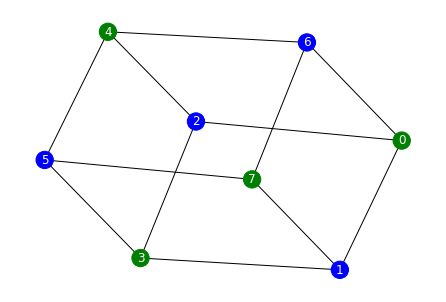

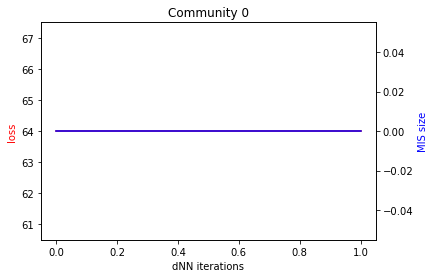

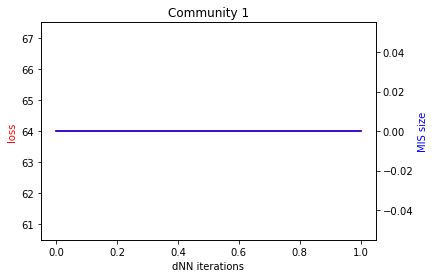

In [73]:
G = build_test_graph1()
calculate_DNN_result(G, calculate_large_G(G), True, "1")

{0, 5}
Length = 2


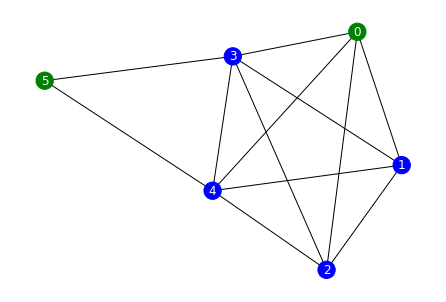

In [67]:
G = nx.graph_atlas(200)
calculate_DNN_result(G, calculate_large_G(G), True, "2.png")

{0, 1, 3, 4}
Length = 4


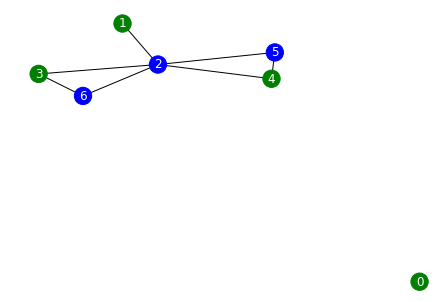

In [68]:
G = nx.graph_atlas(300)
calculate_DNN_result(G, calculate_large_G(G), True, "3.png")

{1, 2, 4, 6}
Length = 4


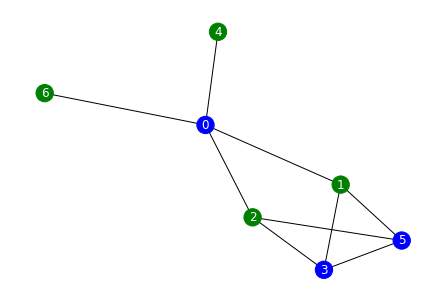

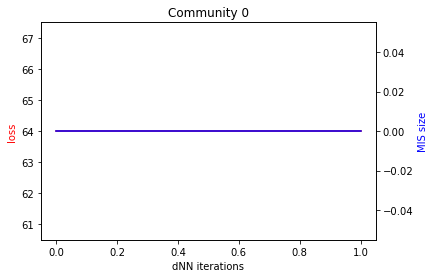

In [69]:
G = nx.graph_atlas(500)
calculate_DNN_result(G, calculate_large_G(G), True, "4.png")

DEBUG:root:Calculating G with nodes = 7 edges = 10
DEBUG:root:Trying find cliques on graph with 7 nodes and 10 edges
DEBUG:root:Total cliques found = 4
DEBUG:root:cliques = {3, 4, 5, 6}
DEBUG:root:Cliques found MIS.
DEBUG:root:Total nodes in MIS = 4
DEBUG:root:Total nodes in MIS={3, 4, 5, 6}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={3, 4, 5, 6}
DEBUG:root:Nodes in MIS after local improvement size=4
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


{3, 4, 5, 6}
Length = 4


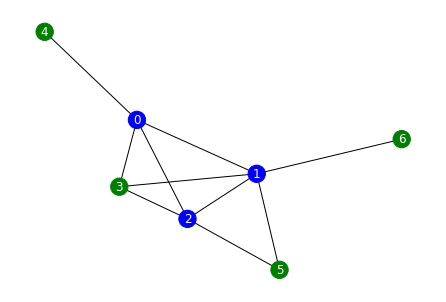

In [118]:
G = nx.graph_atlas(600)
calculate_DNN_result(G, calculate_large_G(G), True, "5.png")

DEBUG:root:Calculating G with nodes = 7 edges = 10
DEBUG:root:Trying find cliques on graph with 7 nodes and 10 edges
DEBUG:root:Total cliques found = 4
DEBUG:root:cliques = {3, 4, 5, 6}
DEBUG:root:Cliques found MIS.
DEBUG:root:Total nodes in MIS = 4
DEBUG:root:Total nodes in MIS={3, 4, 5, 6}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={3, 4, 5, 6}
DEBUG:root:Nodes in MIS after local improvement size=4
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved


{3, 4, 5, 6}
Length = 4


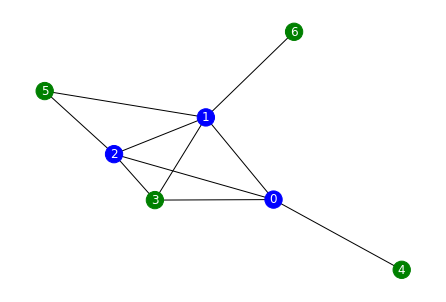

In [119]:
G = nx.graph_atlas(600)
calculate_DNN_result(G, calculate_large_G(G), True, "6.png")

In [120]:
networks = build_n_graphs(20, lambda: nx.erdos_renyi_graph(100,0.1), )

In [70]:
test_network_on_graphs(networks)

NameError: name 'networks' is not defined

In [ ]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(100,0.2), )

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.1))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.2))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
def build_stochastic_params(s,p,q = 0.05):
    sizes = []
    probs = []
    for i in range(5):
        sizes.append(s)
        prob = []
        for j in range(5):
            if i != j:
                prob.append(q)
            else:
                prob.append(p)
        probs.append(prob)
    return (sizes, probs)

In [ ]:
(sizes, probs) = build_stochastic_params(50,0.1)

In [ ]:
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
(sizes, probs) = build_stochastic_params(50,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

In [ ]:
(sizes, probs) = build_stochastic_params(70,0.1)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

In [ ]:
(sizes, probs) = build_stochastic_params(70,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

In [ ]:
networks=build_n_graphs(10, lambda: nx.barabasi_albert_graph(100,45))
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,100))
networks += build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,90))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(100,30,0.5))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(200,60,0.5))

In [ ]:
test_network_on_graphs(networks)

In [55]:
def measure_time_and_result(filepath, path_for_metis, complement=False, reindex=False):
    G=read_G_from_file(filepath)
    if complement:
        G = nx.complement(G)
    if reindex:
        G = reindex_graph(G)
    write_G_to_file_in_metis_format(G, path_for_metis)
    print(G)
    start = time.time()
    result = calculate_large_G(G)
    MIS = result.mis
    end = time.time()
    print("MIS length:{}".format(len(MIS)))
    print("Time used: {} seconds".format(end - start))
    draw_plots(result)

In [ ]:
measure_time_and_result("datasets/Wiki-Vote.txt","datasets/Wiki_Vote.metis", reindex = True,)

In [ ]:
measure_time_and_result("datasets/c1000_9/C1000-9.mtx","datasets/c1000_9/C1000-9_compl.metis", complement = True, reindex = True,)

In [ ]:
measure_time_and_result("datasets/c125-9/C125-9.mtx","datasets/c125-9/C125-9.metis", complement = True, reindex = True,)

In [ ]:
# measure_time_and_result("datasets/C4000-5/C4000-5.mtx","datasets/C4000-5/C4000-5_compl.metis") # Too long to wait

In [ ]:
# measure_time_and_result("datasets/Slashdot0811.txt","datasets/Slashdot0811.metis") # Too long to wait

In [ ]:
measure_time_and_result("datasets/brock200-1/brock200-1.mtx","datasets/brock200-1/brock200-1.metis", complement = True, reindex = True,)

In [ ]:
measure_time_and_result("datasets/brock200-2/brock200-2.mtx","datasets/brock200-2/brock200-2.metis", complement = True, reindex = True,)

Graph with 200 nodes and 10024 edges


DEBUG:root:Calculating G with nodes = 200 edges = 7852
DEBUG:root:Trying find cliques on graph with 200 nodes and 7852 edges


Graph with 200 nodes and 7852 edges


DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 200 nodes and 7852 edges
DEBUG:root:Density of G = 0.39457286432160804
DEBUG:root:Trying find communities solution on graph with 200 nodes and 7852 edges
DEBUG:root:Total communities 7
DEBUG:root:Build network on graph G:Graph with 31 nodes and 266 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Too many edges to process for local search. Trying split graph to communities...
DEBUG:root:Calculating G with nodes = 31 edges = 266
DEBUG:root:Trying find cliques on graph with 31 nodes and 266 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 31 nodes and 266 edges
DEBUG:root:Density of G = 0.5720430107526882
DEBUG:root:Trying find communities solution on graph with 31 nod

DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {8, 18}
DEBUG:root:MIS after all communitites processed length = 5
DEBUG:root:Replacing forbiden nodes
DEBUG:root:mis = {1, 2, 18, 8, 9}
DEBUG:root:Node 1 can be replaced with 21
DEBUG:root:Removing node 9.
DEBUG:root:mis = {2, 18, 21, 8}
DEBUG:root:Node 8 can be replaced with 9
DEBUG:root:MIS after forbidden nodes processed length = 4
DEBUG:root:MIS={2, 18, 21, 9}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={9, 2, 18, 21}
DEBUG:root:MIS after left nodes processed length = 4
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={9, 2, 18, 21}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {9, 2, 18, 21}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={9, 2, 18, 21}
DEBUG:root:Trying local improvement...
DEBUG:ro

DEBUG:root:Local search mis length = 1
DEBUG:root:MIS length = 1
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 1
DEBUG:root:MIS after removing nodes with small degrees in community = {0}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {3}
DEBUG:root:MIS after all communitites processed length = 3
DEBUG:root:Replacing forbiden nodes
DEBUG:root:Removing node 4.
DEBUG:root:MIS after forbidden nodes processed length = 2
DEBUG:root:MIS={3, 5}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={3, 5}
DEBUG:root:MIS after left nodes processed length = 2
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={3, 5}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {3, 5}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in 

DEBUG:root:MIS in community = {2}
DEBUG:root:Build network on graph G:Graph with 7 nodes and 19 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 2 and 6
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {2, 6}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {11, 3}
DEBUG:root:MIS after all communitites processed length = 3
DEBUG:root:Replacing forbiden nodes
DEBUG:root:Removing node 11.
DEBUG:root:mis = {3, 2}
DEBUG:root:Node 2 can be replaced with 10
DEBUG:root:MIS after forbidden nodes processed length = 2
DEBUG:root:MIS

DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {2, 3}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {3, 6}
DEBUG:root:MIS after all communitites processed length = 3
DEBUG:root:Replacing forbiden nodes
DEBUG:root:mis = {1, 3, 6}
DEBUG:root:Node 1 can be replaced with 4
DEBUG:root:MIS after forbidden nodes processed length = 3
DEBUG:root:MIS={3, 4, 6}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={3, 4, 6}
DEBUG:root:MIS after left nodes processed length = 3
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={3, 4, 6}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {3, 4, 6}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={3, 4, 6}
DEBUG:root:Trying local improvement...


DEBUG:root:MIS after all communitites processed length = 34
DEBUG:root:Replacing forbiden nodes
DEBUG:root:Removing node 174.
DEBUG:root:Removing node 190.
DEBUG:root:Removing node 116.
DEBUG:root:Removing node 51.
DEBUG:root:Removing node 122.
DEBUG:root:Removing node 28.
DEBUG:root:Removing node 158.
DEBUG:root:Removing node 153.
DEBUG:root:Removing node 56.
DEBUG:root:Removing node 59.
DEBUG:root:Removing node 147.
DEBUG:root:Removing node 23.
DEBUG:root:Removing node 145.
DEBUG:root:Removing node 135.
DEBUG:root:Removing node 50.
DEBUG:root:Removing node 46.
DEBUG:root:Removing node 38.
DEBUG:root:Removing node 36.
DEBUG:root:mis = {64, 193, 134, 136, 142, 79, 144, 146, 82, 21, 24, 30, 35, 58, 182, 185}
DEBUG:root:Node 146 can be replaced with 169
DEBUG:root:Removing node 144.
DEBUG:root:Removing node 24.
DEBUG:root:Removing node 82.
DEBUG:root:mis = {64, 193, 134, 136, 142, 79, 21, 30, 35, 58, 169, 182, 185}
DEBUG:root:Node 58 can be replaced with 178
DEBUG:root:Removing node 79.


MIS length:11
Time used: 3.4479494094848633 seconds


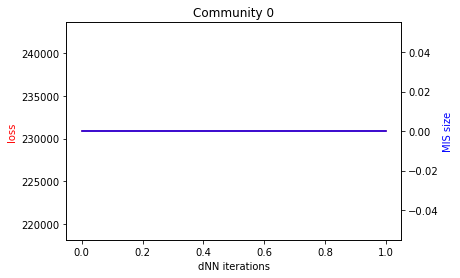

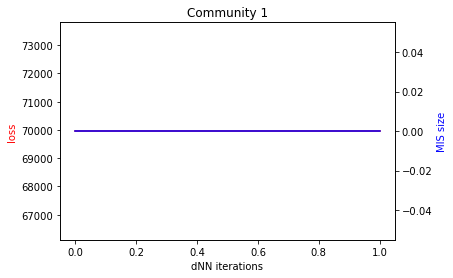

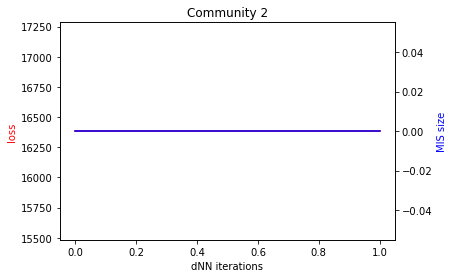

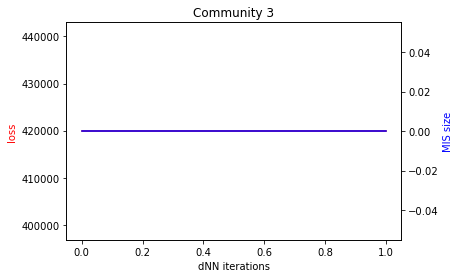

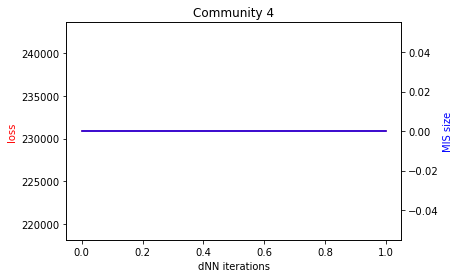

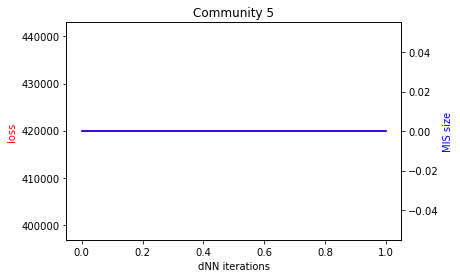

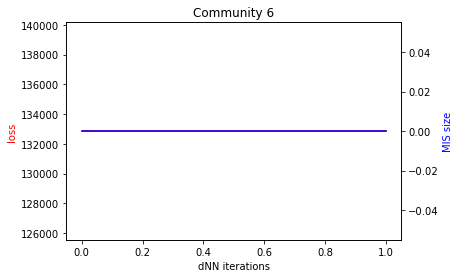

In [74]:
measure_time_and_result("datasets/brock200-3/brock200-3.mtx","datasets/brock200-3/brock200-3.metis", complement = True, reindex = True,)

Graph with 200 nodes and 6811 edges
MIS length:15
Time used: 2.5585179328918457 seconds


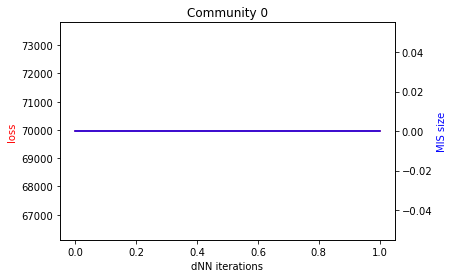

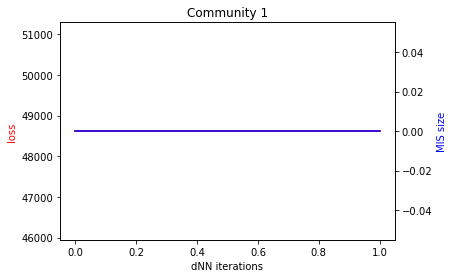

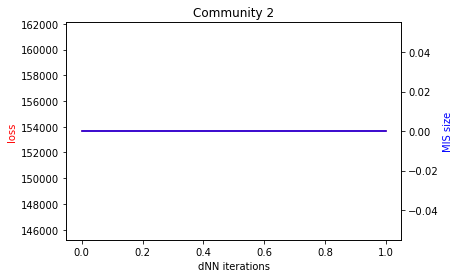

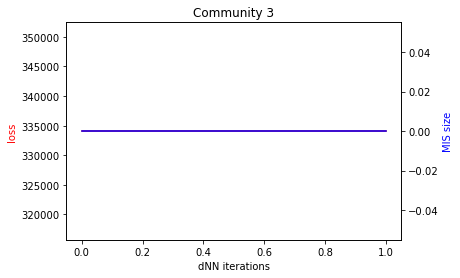

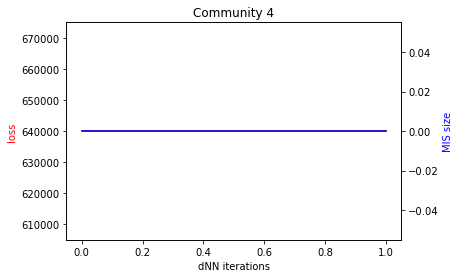

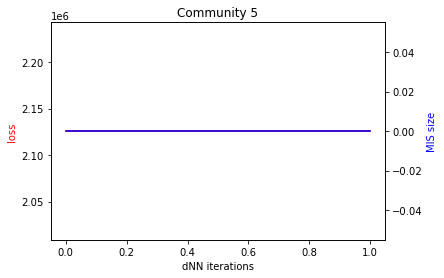

In [61]:
measure_time_and_result("datasets/brock200-4/brock200-4.mtx","datasets/brock200-4/brock200-4.metis", complement = True, reindex = True,)

DEBUG:root:Calculating G with nodes = 800 edges = 111434
DEBUG:root:Trying find cliques on graph with 800 nodes and 111434 edges


Graph with 800 nodes and 111434 edges


DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 800 nodes and 111434 edges
DEBUG:root:Density of G = 0.34866708385481854
DEBUG:root:Trying find communities solution on graph with 800 nodes and 111434 edges
DEBUG:root:Total communities 8
DEBUG:root:Build network on graph G:Graph with 68 nodes and 1119 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Too many edges to process for local search. Trying split graph to communities...
DEBUG:root:Calculating G with nodes = 68 edges = 1119
DEBUG:root:Trying find cliques on graph with 68 nodes and 1119 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 68 nodes and 1119 edges
DEBUG:root:Density of G = 0.49122036874451275
DEBUG:root:Trying find communities solution on graph wi

DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 20 nodes and 126 edges
DEBUG:root:Density of G = 0.6631578947368421
DEBUG:root:Trying find communities solution on graph with 20 nodes and 126 edges
DEBUG:root:Total communities 3
DEBUG:root:Build network on graph G:Graph with 6 nodes and 15 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Local search mis length = 1
DEBUG:root:MIS length = 1
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 1
DEBUG:root:MIS after removing nodes with small degrees in community = {0}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {0}
DEBUG:root:Build network on graph G:Graph with 7

DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {1, 4}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {3, 7}
DEBUG:root:MIS after all communitites processed length = 4
DEBUG:root:Replacing forbiden nodes
DEBUG:root:mis = {3, 10, 19, 7}
DEBUG:root:Node 7 can be replaced with 8
DEBUG:root:Removing node 19.
DEBUG:root:mis = {3, 8, 10}
DEBUG:root:Node 3 can be replaced with 19
DEBUG:root:MIS after forbidden nodes processed length = 3
DEBUG:root:MIS={8, 10, 19}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={8, 10, 19}
DEBUG:root:MIS after left nodes processed length = 3
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={8, 10, 19}
DEBUG:root:Checking lp result is correct.

DEBUG:root:Total nodes in MIS={18, 19, 13}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={18, 19, 13}
DEBUG:root:Nodes in MIS after local improvement size=3
DEBUG:root:validate_dnn_result:IS length = 3
DEBUG:root:MIS length = 3
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 3
DEBUG:root:MIS after removing nodes with small degrees in community = {18, 19, 13}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {104, 63, 119}
DEBUG:root:Build network on graph G:Graph with 18 nodes and 105 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Too many edges to process for local search. Trying split graph to communities...
DEBUG:root:Calculating G with nodes = 18 edges = 105
D

DEBUG:root:MIS after left nodes processed length = 4
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={16, 9, 20, 14}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {16, 9, 20, 14}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={16, 9, 20, 14}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={16, 9, 20, 14}
DEBUG:root:Nodes in MIS after local improvement size=4
DEBUG:root:validate_dnn_result:IS length = 4
DEBUG:root:MIS length = 4
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 4
DEBUG:root:MIS after removing nodes with small degrees in community = {16, 9, 20, 14}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {38, 90, 108, 114}
DEBUG:root:Build network on graph G:Graph with 21 nodes and 133 edges.


DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={10, 12, 13}
DEBUG:root:Nodes in MIS after local improvement size=3
DEBUG:root:validate_dnn_result:IS length = 3
DEBUG:root:MIS length = 3
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 3
DEBUG:root:MIS after removing nodes with small degrees in community = {10, 12, 13}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {57, 20, 21}
DEBUG:root:Build network on graph G:Graph with 24 nodes and 190 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Too many edges to process for local search. Trying split graph to communities...
DEBUG:root:Calculating G with nodes = 24 edges = 190
DEBUG:root:Trying find cliques on graph with 24 nodes and 190 edges
DEBUG:root:Total 

DEBUG:root:Calculating G with nodes = 15 edges = 78
DEBUG:root:Trying find cliques on graph with 15 nodes and 78 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 15 nodes and 78 edges
DEBUG:root:Density of G = 0.7428571428571429
DEBUG:root:Trying find communities solution on graph with 15 nodes and 78 edges
DEBUG:root:Total communities 2
DEBUG:root:Build network on graph G:Graph with 7 nodes and 21 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Local search mis length = 1
DEBUG:root:MIS length = 1
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 1
DEBUG:root:MIS after removing nodes with small degrees in community = {0}
DEBUG:root:Check

DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Too many edges to process for local search. Trying split graph to communities...
DEBUG:root:Calculating G with nodes = 26 edges = 210
DEBUG:root:Trying find cliques on graph with 26 nodes and 210 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 26 nodes and 210 edges
DEBUG:root:Density of G = 0.6461538461538462
DEBUG:root:Trying find communities solution on graph with 26 nodes and 210 edges
DEBUG:root:Total communities 3
DEBUG:root:Build network on graph G:Graph with 8 nodes and 25 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replaci

DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 13 nodes and 62 edges
DEBUG:root:Density of G = 0.7948717948717948
DEBUG:root:Trying find communities solution on graph with 13 nodes and 62 edges
DEBUG:root:Total communities 2
DEBUG:root:Build network on graph G:Graph with 7 nodes and 20 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 4 and 6
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {4, 6}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {4, 7}
DEBUG:ro

DEBUG:root:Removing node 21.
DEBUG:root:Removing node 83.
DEBUG:root:Removing node 12.
DEBUG:root:mis = {2, 69, 39, 38, 78, 81, 20, 56, 31}
DEBUG:root:Node 39 can be replaced with 79
DEBUG:root:Removing node 2.
DEBUG:root:Removing node 31.
DEBUG:root:MIS after forbidden nodes processed length = 7
DEBUG:root:MIS={69, 38, 78, 79, 81, 20, 56}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={81, 20, 69, 38, 56, 78, 79}
DEBUG:root:MIS after left nodes processed length = 7
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={81, 20, 69, 38, 56, 78, 79}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {69, 38, 78, 79, 81, 20, 56}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={81, 20, 69, 38, 56, 78, 79}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Re

DEBUG:root:MIS={0, 4, 9}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={0, 9, 4}
DEBUG:root:MIS after left nodes processed length = 3
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={0, 9, 4}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {0, 9, 4}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={0, 9, 4}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={0, 9, 4}
DEBUG:root:Nodes in MIS after local improvement size=3
DEBUG:root:validate_dnn_result:IS length = 3
DEBUG:root:MIS length = 3
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 3
DEBUG:root:MIS after removing nodes with small degrees in community = {0, 9, 4}
DEBUG:root:Checking community 

DEBUG:root:MIS in community = {8, 2}
DEBUG:root:MIS after all communitites processed length = 4
DEBUG:root:Replacing forbiden nodes
DEBUG:root:mis = {0, 1, 2, 8}
DEBUG:root:Node 0 can be replaced with 12
DEBUG:root:Removing node 2.
DEBUG:root:MIS after forbidden nodes processed length = 3
DEBUG:root:MIS={1, 8, 12}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={8, 1, 12}
DEBUG:root:MIS after left nodes processed length = 3
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={8, 1, 12}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {8, 1, 12}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={8, 1, 12}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={8, 1, 12}
DEBUG:root:Nodes in MIS after local improvement size

DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Too many edges to process for local search. Trying split graph to communities...
DEBUG:root:Calculating G with nodes = 102 edges = 2354
DEBUG:root:Trying find cliques on graph with 102 nodes and 2354 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 102 nodes and 2354 edges
DEBUG:root:Density of G = 0.45699864104057464
DEBUG:root:Trying find communities solution on graph with 102 nodes and 2354 edges
DEBUG:root:Total communities 5
DEBUG:root:Build network on graph G:Graph with 16 nodes and 88 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Too many edges to process for local search. Trying split graph to communities...
DEBUG:root:Calculating G with nodes = 16 edges = 88
DEBUG:root:Trying 

DEBUG:root:mis = {16, 18, 3, 2, 8}
DEBUG:root:Node 3 can be replaced with 9
DEBUG:root:Removing node 8.
DEBUG:root:mis = {16, 18, 2, 9}
DEBUG:root:Node 2 can be replaced with 11
DEBUG:root:mis = {16, 18, 9, 11}
DEBUG:root:Node 16 can be replaced with 15
DEBUG:root:MIS after forbidden nodes processed length = 4
DEBUG:root:MIS={18, 9, 11, 15}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={9, 18, 11, 15}
DEBUG:root:MIS after left nodes processed length = 4
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={9, 18, 11, 15}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {9, 18, 11, 15}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={9, 18, 11, 15}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={9, 18, 11, 15}


DEBUG:root:Trying to use local improvement...
DEBUG:root:Local search mis length = 1
DEBUG:root:MIS length = 1
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 1
DEBUG:root:MIS after removing nodes with small degrees in community = {0}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {0}
DEBUG:root:Build network on graph G:Graph with 5 nodes and 10 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Local search mis length = 1
DEBUG:root:MIS length = 1
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 1
DEBUG:root:MIS after removing nodes with small degrees in community = {0}
DEBUG:root:Checking community result is co

DEBUG:root:Node 61 can be replaced with 43
DEBUG:root:Removing node 37.
DEBUG:root:Removing node 98.
DEBUG:root:Removing node 20.
DEBUG:root:mis = {67, 5, 9, 77, 15, 21, 84, 25, 28, 42, 43}
DEBUG:root:Node 67 can be replaced with 20
DEBUG:root:Removing node 84.
DEBUG:root:Removing node 77.
DEBUG:root:mis = {5, 9, 15, 20, 21, 25, 28, 42, 43}
DEBUG:root:Node 28 can be replaced with 51
DEBUG:root:Removing node 42.
DEBUG:root:mis = {5, 9, 15, 20, 21, 25, 43, 51}
DEBUG:root:Node 15 can be replaced with 48
DEBUG:root:mis = {5, 9, 20, 21, 25, 43, 48, 51}
DEBUG:root:Node 21 can be replaced with 94
DEBUG:root:mis = {5, 9, 20, 25, 94, 43, 48, 51}
DEBUG:root:Node 25 can be replaced with 78
DEBUG:root:Removing node 9.
DEBUG:root:MIS after forbidden nodes processed length = 7
DEBUG:root:MIS={5, 78, 20, 94, 43, 48, 51}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={48, 51, 20, 5, 94, 43, 78}
DEBUG:root:MIS afte

DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {0}
DEBUG:root:Build network on graph G:Graph with 8 nodes and 24 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 2 and 4
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {2, 4}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {8, 16}
DEBUG:root:Build network on graph G:Graph with 10 nodes and 39 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN

DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {3, 5}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {15, 7}
DEBUG:root:Build network on graph G:Graph with 7 nodes and 20 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 3 and 4
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {3, 4}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {8, 6}
DEBUG:root:Build ne

DEBUG:root:mis = {6, 78, 16, 94, 31, 103, 54}
DEBUG:root:Node 6 can be replaced with 11
DEBUG:root:MIS after forbidden nodes processed length = 7
DEBUG:root:MIS={11, 78, 16, 94, 31, 103, 54}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={16, 54, 103, 94, 11, 78, 31}
DEBUG:root:MIS after left nodes processed length = 7
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={16, 54, 103, 94, 11, 78, 31}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {103, 11, 78, 16, 54, 94, 31}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={16, 54, 103, 94, 11, 78, 31}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 78 with 40 and 82
DEBUG:root:Local improvement increased MIS by 1
DEBUG:root:Nodes in MIS after local improvement={16, 54, 103, 94, 11, 78,

DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {2, 4}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {18, 13}
DEBUG:root:Build network on graph G:Graph with 11 nodes and 48 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 1 and 3
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {1, 3}
DEBUG:root:Checking community result is 

DEBUG:root:Node 0 can be replaced with 6
DEBUG:root:MIS after forbidden nodes processed length = 4
DEBUG:root:MIS={6, 10, 11, 13}
DEBUG:root:Left nodes = []
DEBUG:root:Left nodes length = 0
DEBUG:root:mis of left nodes = []
DEBUG:root:MIS after left nodes processed={10, 11, 13, 6}
DEBUG:root:MIS after left nodes processed length = 4
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={10, 11, 13, 6}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {10, 11, 13, 6}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={10, 11, 13, 6}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={10, 11, 13, 6}
DEBUG:root:Nodes in MIS after local improvement size=4
DEBUG:root:validate_dnn_result:IS length = 4
DEBUG:root:MIS length = 4
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with 

DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 1 and 6
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {1, 6}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {16, 5}
DEBUG:root:Build network on graph G:Graph with 11 nodes and 44 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 1 and 6
DEB

DEBUG:root:Total communities 4
DEBUG:root:Build network on graph G:Graph with 9 nodes and 32 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 1 and 5
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {1, 5}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {20, 13}
DEBUG:root:Build network on graph G:Graph with 5 nodes and 10 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using l

DEBUG:root:MIS after LP nodes processed={11, 2, 3, 4}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {3, 2, 11, 4}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={3, 2, 11, 4}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 2 with 12 and 21
DEBUG:root:Local improvement increased MIS by 1
DEBUG:root:Nodes in MIS after local improvement={3, 2, 11, 4}
DEBUG:root:Nodes in MIS after local improvement size=4
DEBUG:root:validate_dnn_result:IS length = 5
DEBUG:root:MIS length = 5
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 5
DEBUG:root:MIS after removing nodes with small degrees in community = {3, 4, 11, 12, 21}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {98, 99, 13, 14, 51}
DEBUG:root:MIS after all communitites processed length = 20
DEBUG:root:Replacing forbiden no

MIS length:15
Time used: 68.3112964630127 seconds


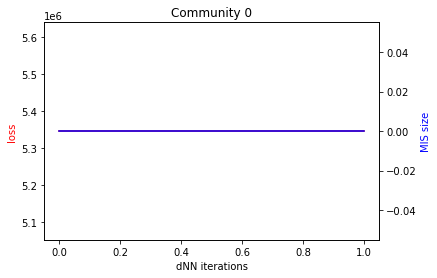

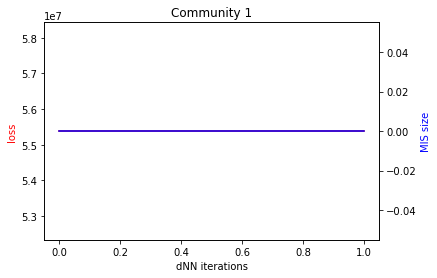

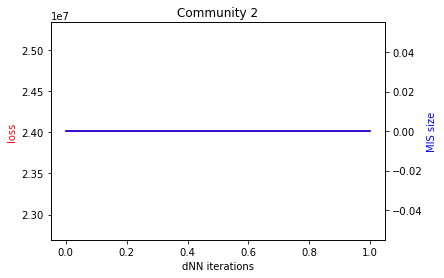

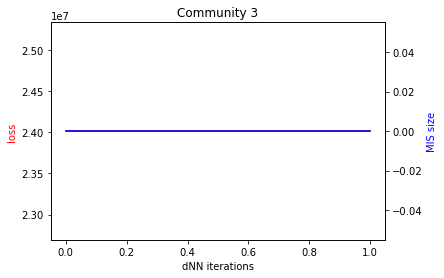

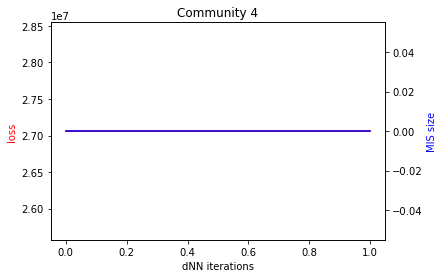

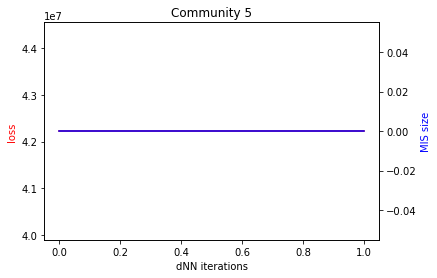

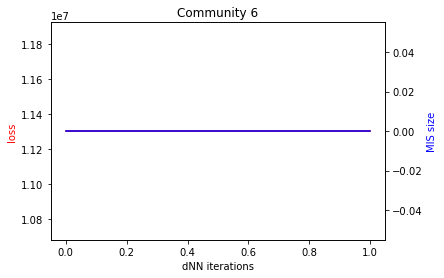

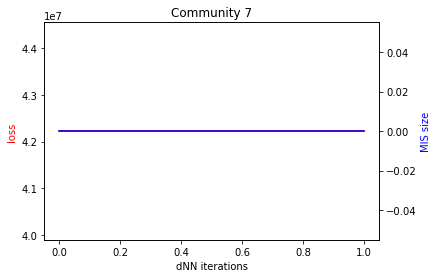

In [77]:
measure_time_and_result("datasets/brock800-2/brock800-2.mtx","datasets/brock800-2/brock800-2.metis", complement = True, reindex = True,)

Graph with 171 nodes and 5100 edges
MIS length:11
Time used: 21.765130043029785 seconds


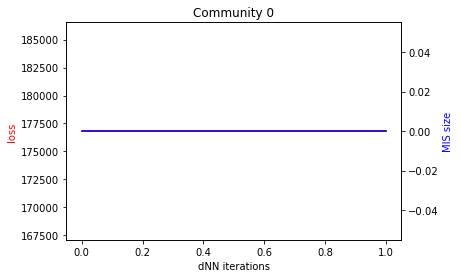

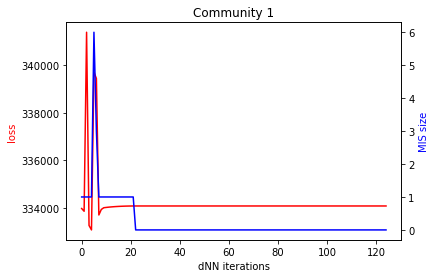

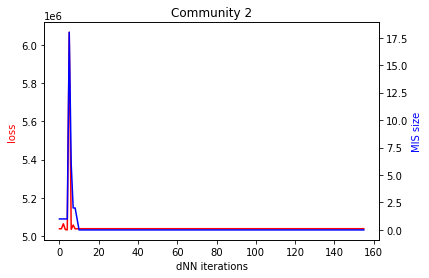

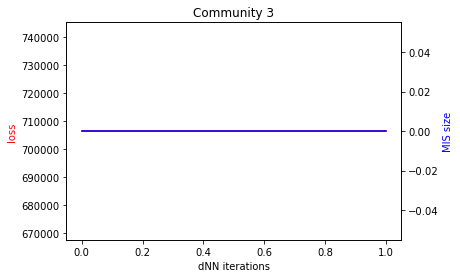

In [60]:
measure_time_and_result("datasets/keller4/keller4.mtx","datasets/keller4/keller4.metis", complement = True, reindex = True,)

Graph with 378 nodes and 702 edges
MIS length:121
Time used: 5.232999086380005 seconds


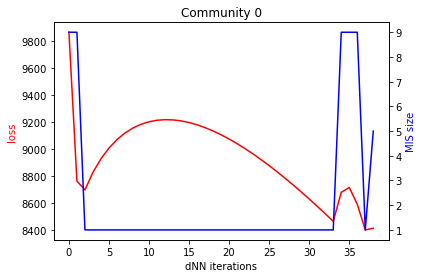

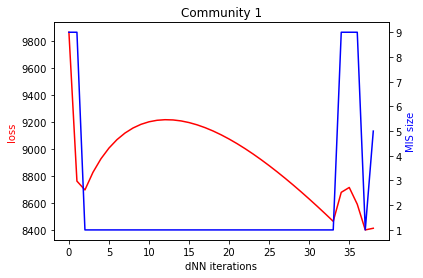

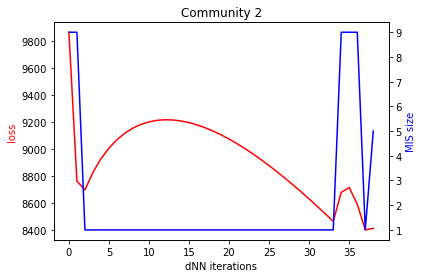

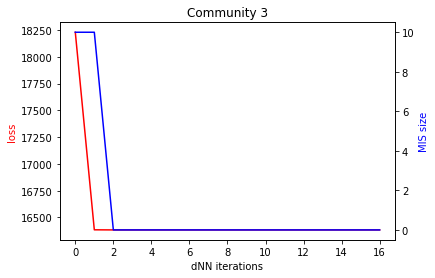

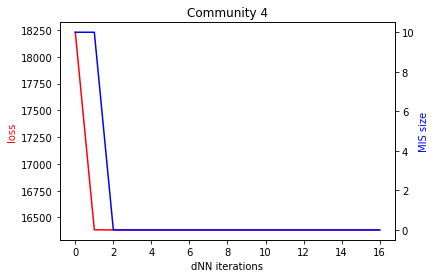

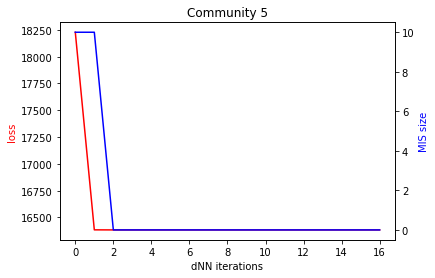

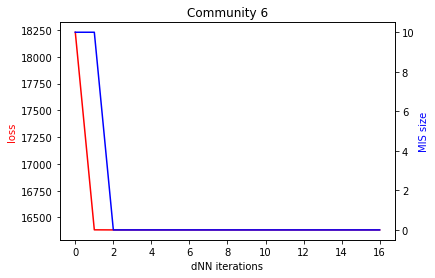

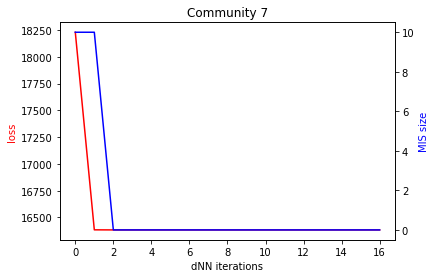

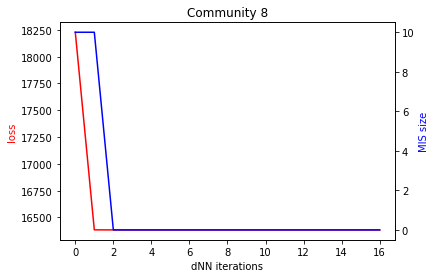

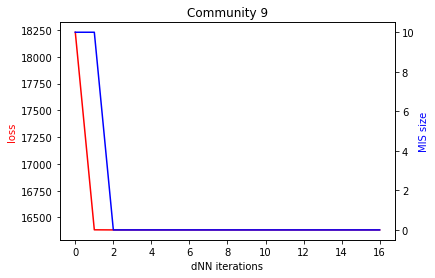

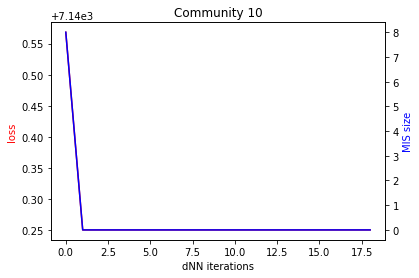

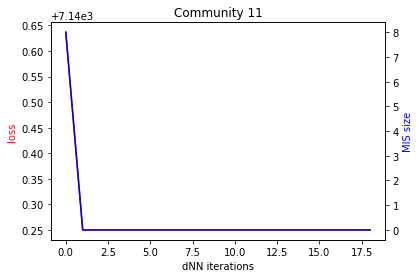

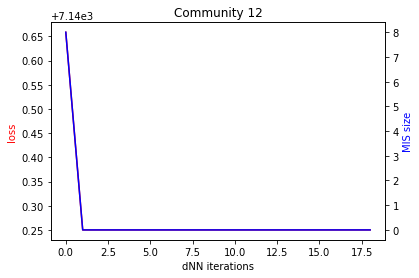

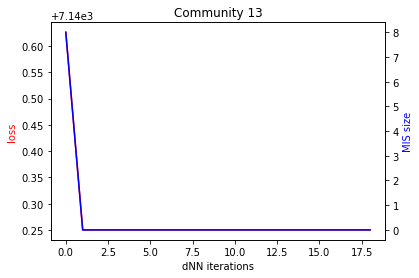

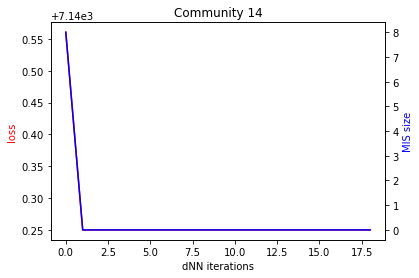

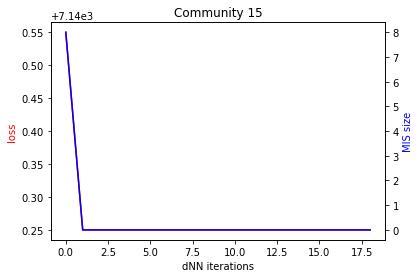

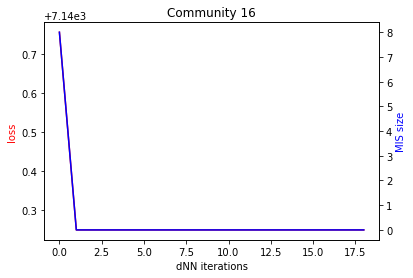

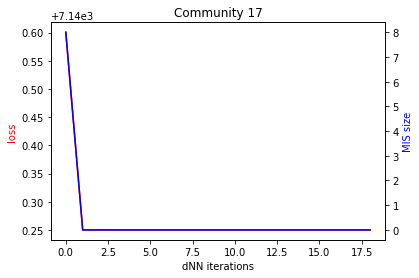

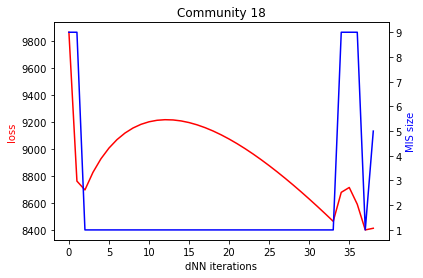

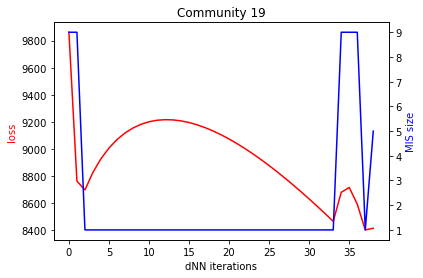

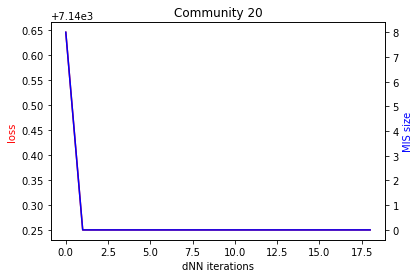

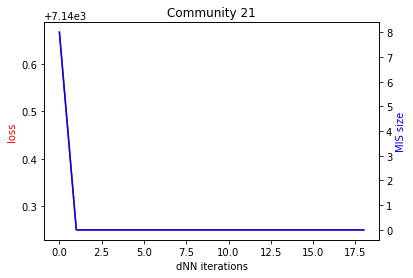

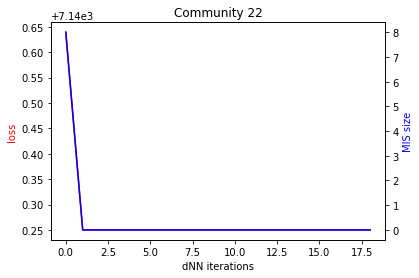

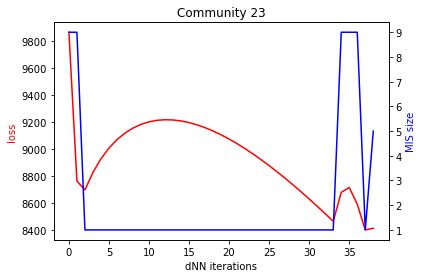

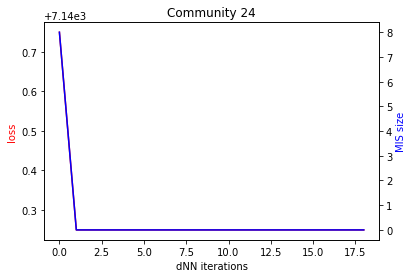

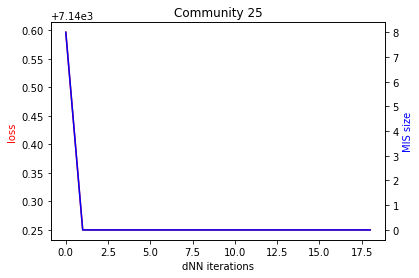

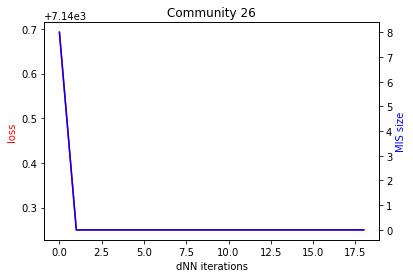

In [59]:
measure_time_and_result("datasets/MANN-a27/MANN-a27.mtx","datasets/MANN-a27/MANN-a27.metis", complement = True, reindex = True,)

Graph with 300 nodes and 11460 edges
MIS length:30
Time used: 30.145305156707764 seconds


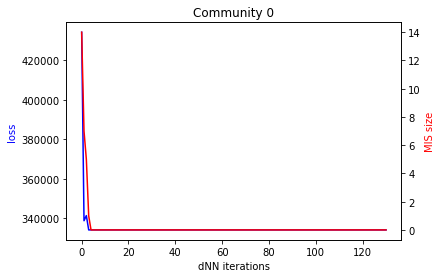

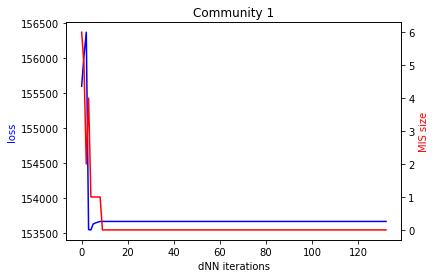

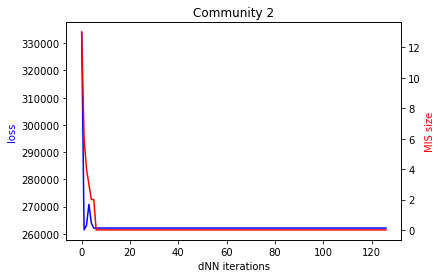

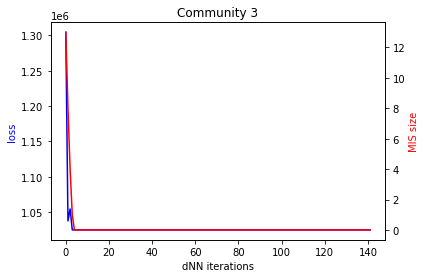

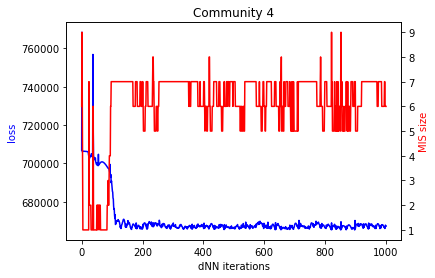

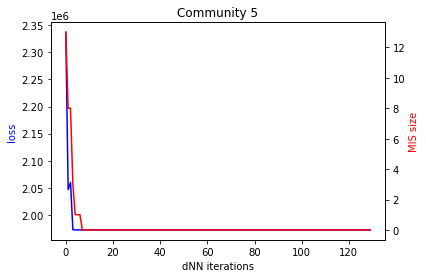

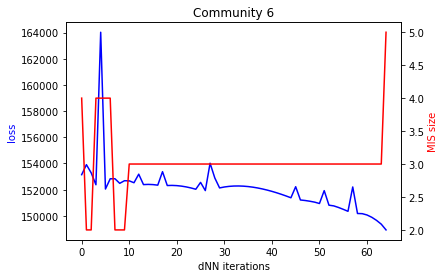

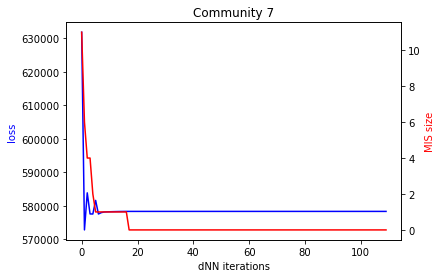

In [153]:
measure_time_and_result("datasets/p-hat300-3/p-hat300-3.mtx","datasets/p-hat300-3/p-hat300-3.metis", complement = True, reindex = True,)

Graph with 200 nodes and 6032 edges
MIS length:14
Time used: 3.985041856765747 seconds


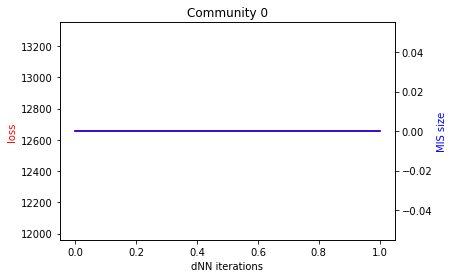

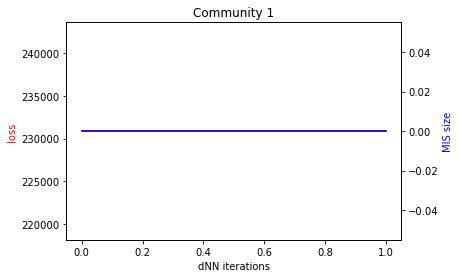

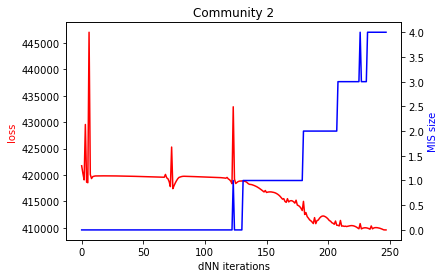

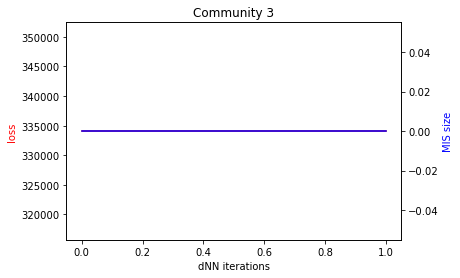

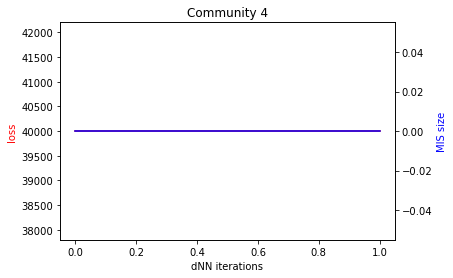

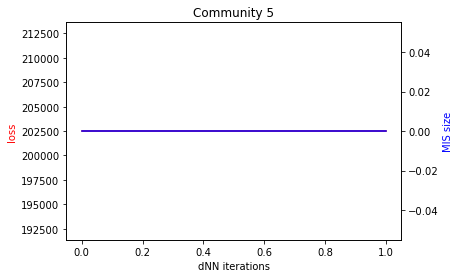

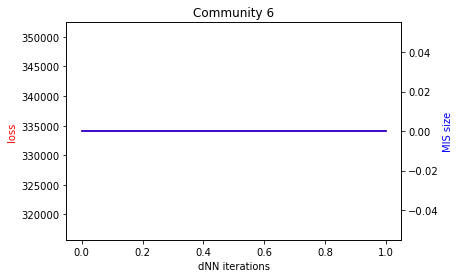

In [66]:
measure_time_and_result("datasets/sanr200-0-7/sanr200-0-7.mtx","datasets/sanr200-0-7/sanr200-0-7.metis", complement = True, reindex = True,)

DEBUG:root:Calculating G with nodes = 200 edges = 2037
DEBUG:root:Trying find cliques on graph with 200 nodes and 2037 edges
DEBUG:root:Total cliques found = 0
DEBUG:root:cliques = set()
DEBUG:root:Trying find LP solution on graph with 200 nodes and 2037 edges
DEBUG:root:Density of G = 0.10236180904522613
DEBUG:root:Trying find communities solution on graph with 200 nodes and 2037 edges
DEBUG:root:Total communities 9
DEBUG:root:Build network on graph G:Graph with 17 nodes and 44 edges.


Graph with 200 nodes and 2037 edges


DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Epochs exceeded maximum
DEBUG:root:Total epochs = 1000
DEBUG:root:dNN solution lenghth = 3
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 2 and 16
DEBUG:root:Replacing 2 with 1 and 3
DEBUG:root:Replacing 1 with 6 and 11
DEBUG:root:Replacing 3 with 4 and 14
DEBUG:root:Local search mis length = 5
DEBUG:root:MIS length = 5
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 5
DEBUG:root:MIS after removing nodes with small degrees in community = {4, 6, 11, 14, 16}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {41, 174, 14, 150, 189}
DEBUG:root:Build network on graph G:Graph with 25 nodes and 73 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 125
DEBUG:root:dN

DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 with 3 and 4
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees in community = {3, 4}
DEBUG:root:Checking community result is correct...
DEBUG:root:MIS in community = {10, 7}
DEBUG:root:Build network on graph G:Graph with 7 nodes and 11 edges.
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Epochs exceeded maximum
DEBUG:root:Total epochs = 1000
DEBUG:root:dNN solution lenghth = 2
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Replacing 0 wit

DEBUG:root:MIS after left nodes processed length = 10
DEBUG:root:Checking main algo result is correct...
DEBUG:root:MIS after LP nodes processed={32, 34, 35, 37, 9, 12, 13, 18, 26, 27}
DEBUG:root:Checking lp result is correct...
DEBUG:root:MIS after cliques processed = {32, 34, 35, 37, 9, 12, 13, 18, 26, 27}
DEBUG:root:Checking cliques result is correct...
DEBUG:root:Total nodes in MIS={32, 34, 35, 37, 9, 12, 13, 18, 26, 27}
DEBUG:root:Trying local improvement...
DEBUG:root:Trying to use local improvement...
DEBUG:root:Nodes in MIS after local improvement={32, 34, 35, 37, 9, 12, 13, 18, 26, 27}
DEBUG:root:Nodes in MIS after local improvement size=10
DEBUG:root:validate_dnn_result:IS length = 10
DEBUG:root:MIS length = 10
DEBUG:root:Trying to use local improvement...
DEBUG:root:MIS after removing nodes with small degrees length = 10
DEBUG:root:MIS after removing nodes with small degrees in community = {32, 34, 35, 37, 9, 12, 13, 18, 26, 27}
DEBUG:root:Checking community result is correc

DEBUG:root:Node 34 can be replaced with 113
DEBUG:root:mis = {130, 128, 132, 5, 6, 138, 14, 142, 19, 148, 21, 149, 23, 152, 32, 37, 39, 166, 165, 170, 45, 49, 55, 189, 65, 193, 66, 83, 95, 97, 101, 105, 106, 109, 113, 123, 124, 125}
DEBUG:root:Node 132 can be replaced with 8
DEBUG:root:mis = {5, 6, 8, 14, 19, 21, 23, 32, 37, 39, 45, 49, 55, 65, 66, 83, 95, 97, 101, 105, 106, 109, 113, 123, 124, 125, 128, 130, 138, 142, 148, 149, 152, 165, 166, 170, 189, 193}
DEBUG:root:Node 106 can be replaced with 161
DEBUG:root:Removing node 124.
DEBUG:root:mis = {5, 6, 8, 14, 19, 21, 23, 32, 37, 39, 45, 49, 55, 65, 66, 83, 95, 97, 101, 105, 109, 113, 123, 125, 128, 130, 138, 142, 148, 149, 152, 161, 165, 166, 170, 189, 193}
DEBUG:root:Node 165 can be replaced with 141
DEBUG:root:Removing node 37.
DEBUG:root:Removing node 193.
DEBUG:root:Removing node 14.
DEBUG:root:Removing node 66.
DEBUG:root:Removing node 23.
DEBUG:root:MIS after forbidden nodes processed length = 32
DEBUG:root:MIS={5, 6, 8, 19, 2

MIS length:35
Time used: 25.744631052017212 seconds


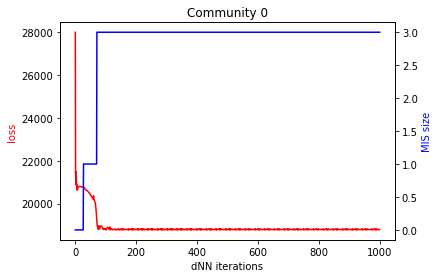

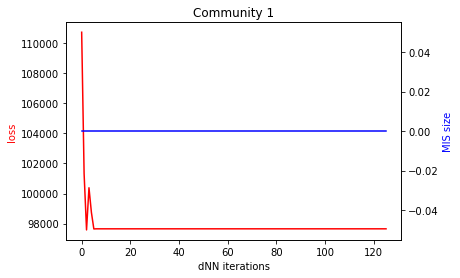

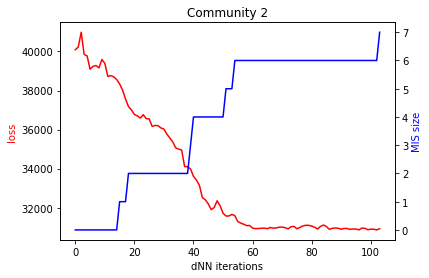

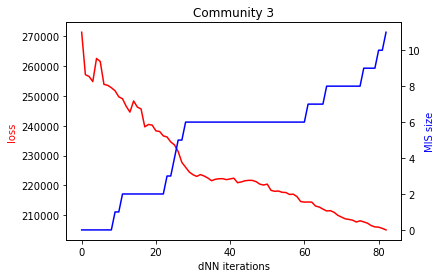

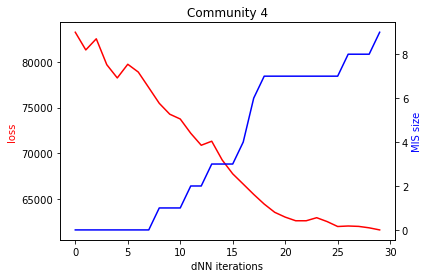

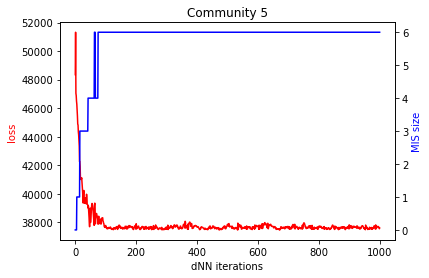

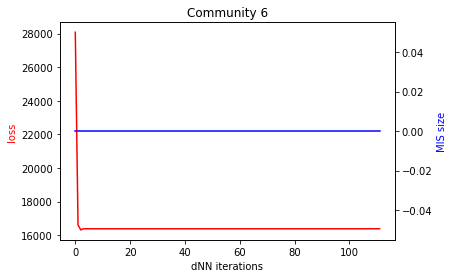

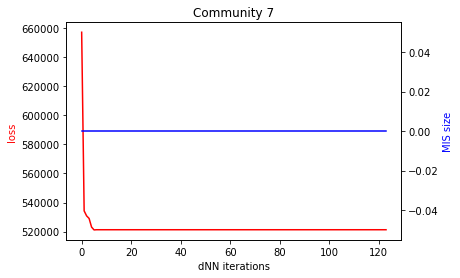

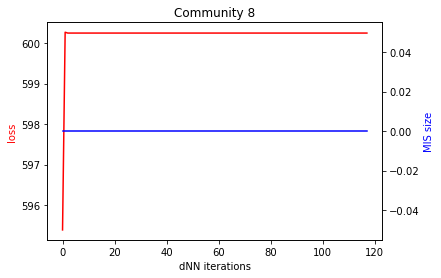

In [78]:
measure_time_and_result("datasets/sanr200-0-9/sanr200-0-9.mtx","datasets/sanr200-0-9/sanr200-0-9.metis", complement = True, reindex = True,)